# Curve Fitting in Planetary Data Analysis

### Importance of Curve Fitting
In planetary science, curve fitting is essential for modeling complex relationships between variables. It helps with tasks like identifying trends in data, noise reduction, and extrapolating missing or uncertain data points.

### Common Use Cases in Planetary Science
- **Spectral Data Analysis:** Fitting curves to spectral data to identify specific mineralogical signatures.
- **Topographic Analysis:** Using curve fitting to model terrain features from elevation datasets.
- **Time Series Analysis:** Analyzing variations in surface or atmospheric conditions over time.


# Multilayer Perceptrons (MLPs) in Curve Fitting

A Multilayer Perceptron (MLP) is a type of neural network useful for approximating complex functions. MLPs are fully connected networks - meaning each node in the network is connected to every node in the previous and next layer. Unlike polynomial or linear regression, MLPs can model highly non-linear relationships.

![SegmentLocal](/Users/phillipsm/Documents/Teaching/AI_in_PlanetaryXXX/Code/02_Curve_Fitting/files/mlp.gif)

A great description of MLPs is found in the following video for a visual explanation: [3Blue1Brown Neural Networks Playlist](https://www.youtube.com/watch?v=aircAruvnKk).


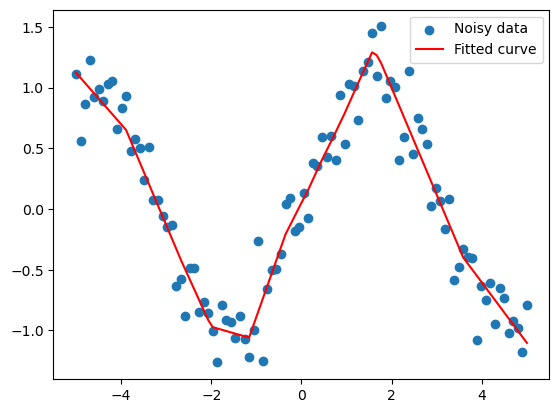

In [1]:
# Example: Training an MLP for Curve Fitting

# We will fit an MLP to noisy sinusoidal data using PyTorch (you can use TensorFlow as an alternative).
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generating noisy data
x = np.linspace(-5, 5, 100).reshape(-1, 1)
y = np.sin(x) + 0.2 * np.random.normal(size=x.shape)

# Define MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(1, 64)
        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x

# Prepare data for training
model = MLP()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Convert numpy arrays to torch tensors
x_train = torch.tensor(x, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32)

# Training loop
for epoch in range(1000):
    model.train()
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot results
plt.scatter(x, y, label='Noisy data')
plt.plot(x, model(x_train).detach().numpy(), label='Fitted curve', color='red')
plt.legend()
plt.show()


# Case Study: CRISM Noise Remediation

In planetary science, CRISM data (Compact Reconnaissance Imaging Spectrometer for Mars) can be noisy due to instrumental effects. MLPs can be used to fit curves to spectral data, modeling and removing noise for better analysis of surface mineralogy.

For further exploration, students can access public CRISM datasets and apply MLPs for noise remediation.


# Polynomial Regression for Curve Fitting

Polynomial regression fits a polynomial curve to data by extending the linear regression model to higher powers of the input features. It is commonly used when the relationship between variables is non-linear.

## Polynomial Regression Formula:
#### y = b_0 + b_1*x + b_2*x^2 + ... + b_n*x^n

Polynomial regression is often used for curve fitting in situations like fitting the surface temperature curves on Mars or for trajectory analysis in space missions.


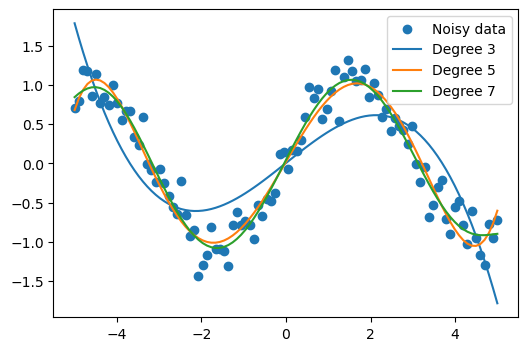

Best fit is degree 3


In [43]:
# Example: Polynomial Regression with scikit-learn

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Generate synthetic data
x = np.linspace(-5, 5, 100).reshape(-1, 1)
y = np.sin(x) + 0.2 * np.random.normal(size=x.shape)

# Polynomial regression model (degree 3)
deg_list = [3, 5, 7]
chi2_list = []
plt.figure(figsize=(6,4))
plt.scatter(x, y, label='Noisy data')

for deg in deg_list:
    model = make_pipeline(PolynomialFeatures(degree=deg), LinearRegression())
    model.fit(x, y)
    y_pred = model.predict(x)
    # calculate the best fit with chi2
    chi2 = np.abs(np.sum((y - y_pred)**2 / y_pred))
    chi2_list.append(chi2)
    plt.plot(x, y_pred, label=f'Degree {deg}')
    plt.legend()

plt.show()

best_fit = deg_list[np.argmin(chi2_list)]
print(f"Best fit is degree {best_fit}")
print(chi2_list)


# Bayesian Neural Networks (BNNs) in Curve Fitting

Bayesian Neural Networks (BNNs) extend standard neural networks by placing probability distributions over the network weights. This allows BNNs to provide uncertainty estimates alongside predictions, which is useful in planetary science when dealing with noisy or incomplete data.


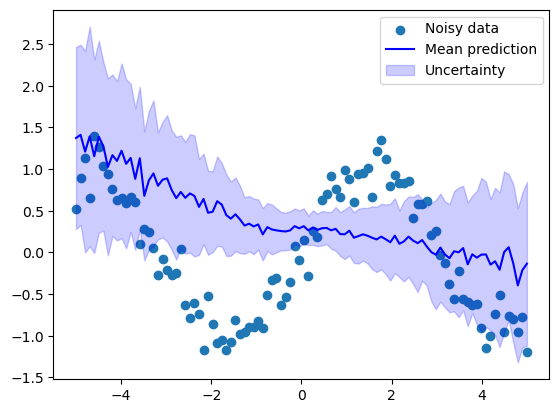

In [17]:
# Example: BNN Approximation with MC Dropout

# MC Dropout: A technique for approximating BNNs by enabling dropout during prediction, simulating a Bayesian-like model.

# We'll modify the MLP model from before to use dropout layers.

class MLPWithDropout(nn.Module):
    def __init__(self):
        super(MLPWithDropout, self).__init__()
        self.hidden = nn.Linear(1, 64)
        self.dropout = nn.Dropout(p=0.5)
        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.dropout(x)  # Dropout applied at each pass
        x = self.output(x)
        return x

# Training and prediction proceed similarly, but we’ll now use multiple forward passes to estimate uncertainty.
# Run multiple predictions (e.g., 100) to approximate the posterior distribution of predictions.

model = MLPWithDropout()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model (similar to previous MLP example)

# Simulate multiple predictions for uncertainty estimation
y_preds = []
for _ in range(10000):
    model.train()  # Keep dropout enabled

for _ in range(100):
    y_pred = model(x_train)
    y_preds.append(y_pred.detach().numpy())

y_preds_mean = np.mean(y_preds, axis=0)
y_preds_std = np.std(y_preds, axis=0)

# Plot the mean prediction and uncertainty bounds
plt.scatter(x, y, label='Noisy data')
plt.plot(x, y_preds_mean, label='Mean prediction', color='blue')
plt.fill_between(x.flatten(), y_preds_mean.flatten() - y_preds_std.flatten(), 
                 y_preds_mean.flatten() + y_preds_std.flatten(), color='blue', alpha=0.2, label='Uncertainty')
plt.legend()
plt.show()
